In [4]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

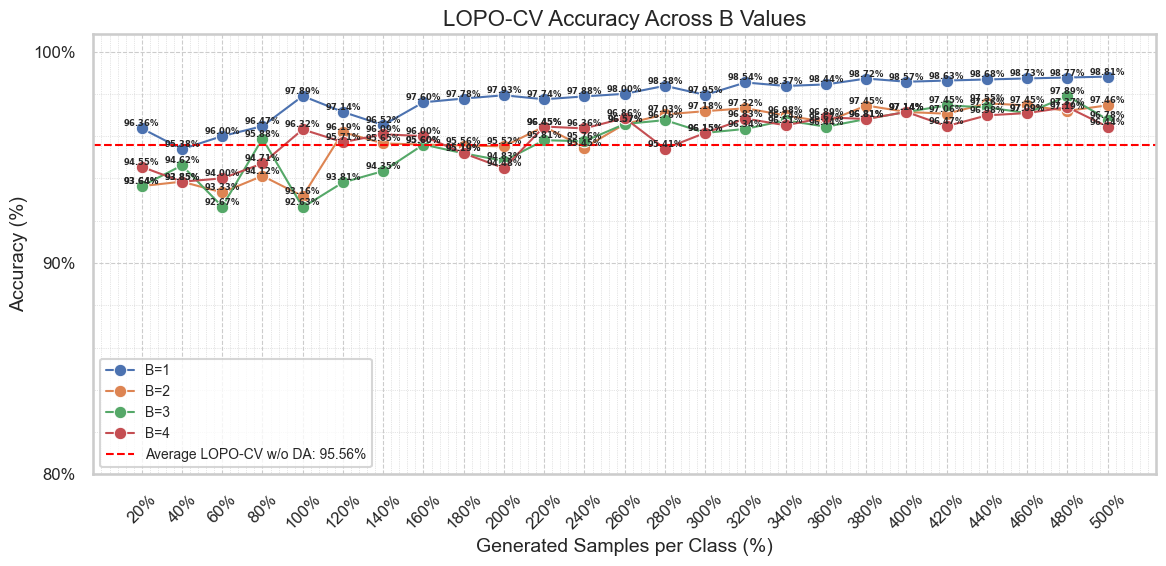

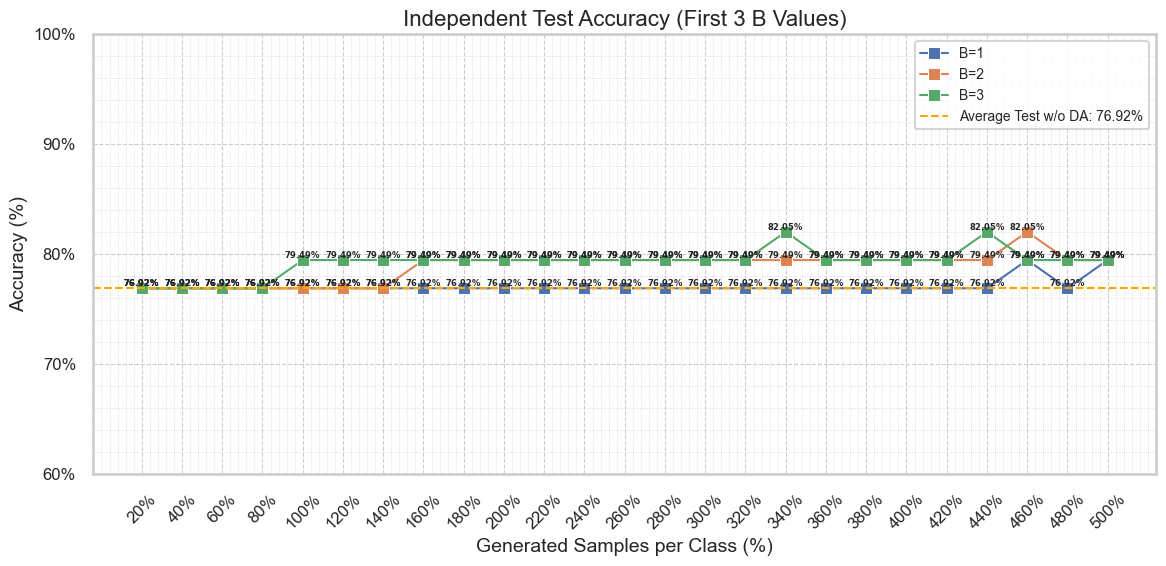

In [5]:
# 2. 載入所有歷史紀錄
histories = []
for p in paths:
    with open(p, 'rb') as f:
        histories.append(pickle.load(f))

# 3. 提取 gen_counts, LOPO-CV 和獨立測試分數
gen_counts = np.array(histories[0]['gen_counts'])
loocv_matrix = np.array([h['loocv_scores'] for h in histories]) * 100  # shape (4, N)
test_matrix  = np.array([h['test_scores']  for h in histories]) * 100  # shape (4, N)
labels = [f'B={i+1}' for i in range(len(histories))]

# -----------------------------------------------------------------------------
# 4. 繪製一張圖：全部 4 條 LOPO-CV 折線
# -----------------------------------------------------------------------------
# Flatten 取極值以決定 y 軸範圍
all_loocv = loocv_matrix.flatten()
min_val = all_loocv.min()
lower = max(int(np.floor((min_val - 10)/10)) * 10, 0)
upper = min(all_loocv.max() + 2, 102)

sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 6))

for idx, loocv in enumerate(loocv_matrix):
    sns.lineplot(
        x=gen_counts, y=loocv,
        marker="o", linewidth=1.5,
        label=labels[idx], ax=ax, clip_on=False
    )
    # 加上每個點的數值標註
    for x, y in zip(gen_counts, loocv):
        ax.text(
            x, y, f"$\\mathbf{{{y:.2f}\\%}}$",
            va='bottom', ha='center',
            fontsize=6, clip_on=False
        )

# 加入 LOPO-CV 無 DA 的基準線
baseline = 95.56
ax.axhline(
    baseline, linestyle='--',
    label=f'Average LOPO-CV w/o DA: {baseline}%',
    clip_on=False, color='red', linewidth=1.5
)

# X, Y 軸設定
ax.set_xticks(gen_counts)
ax.set_xticklabels([f"{int(x*2)}%" for x in gen_counts], rotation=45)
ax.set_ylim(lower, upper)
yticks = list(range(lower, 101, 10))
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y}%" for y in yticks])
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Generated Samples per Class (%)", fontsize=14)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_title("LOPO-CV Accuracy Across B Values", fontsize=16)
ax.minorticks_on()
ax.grid(which="major", linestyle="--", linewidth=0.8)
ax.grid(which="minor", linestyle=":", linewidth=0.5)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------------------
# 5. 繪製另一張圖：取前三組（或自行調整）的獨立測試結果
# -----------------------------------------------------------------------------
# 假設只要前三個 B 值的結果
test_indices = [0, 1, 2]
sel_test = test_matrix[test_indices]

# Flatten 取極值以決定 y 軸範圍
all_test = sel_test.flatten()
min_val2 = all_test.min()
lower2 = max(int(np.floor((min_val2 - 10)/10)) * 10, 0)
upper2 = min(all_test.max() + 2, 102)

fig, ax = plt.subplots(figsize=(12, 6))

for i, idx in enumerate(test_indices):
    test_scores = test_matrix[idx]
    sns.lineplot(
        x=gen_counts, y=test_scores,
        marker="s", linewidth=1.5,
        label=labels[idx], ax=ax, clip_on=False
    )
    for x, y in zip(gen_counts, test_scores):
        ax.text(
            x, y, f"$\\mathbf{{{y:.2f}\\%}}$",
            va='bottom', ha='center',
            fontsize=6, clip_on=False
        )

# 加入獨立測試集無 DA 的基準線
baseline2 = 76.92
ax.axhline(
    baseline2, linestyle='--',
    label=f'Average Test w/o DA: {baseline2}%',
    clip_on=False, color='orange', linewidth=1.5
)

# X, Y 軸設定
ax.set_xticks(gen_counts)
ax.set_xticklabels([f"{int(x*2)}%" for x in gen_counts], rotation=45)
ax.set_ylim(lower2, upper2)
yticks2 = list(range(lower2, 101, 10))
ax.set_yticks(yticks2)
ax.set_yticklabels([f"{y}%" for y in yticks2])
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Generated Samples per Class (%)", fontsize=14)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_title("Independent Test Accuracy (First 3 B Values)", fontsize=16)
ax.minorticks_on()
ax.grid(which="major", linestyle="--", linewidth=0.8)
ax.grid(which="minor", linestyle=":", linewidth=0.5)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

C:\Users\Well\AppData\Local\Temp\ipykernel_25524\808451765.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


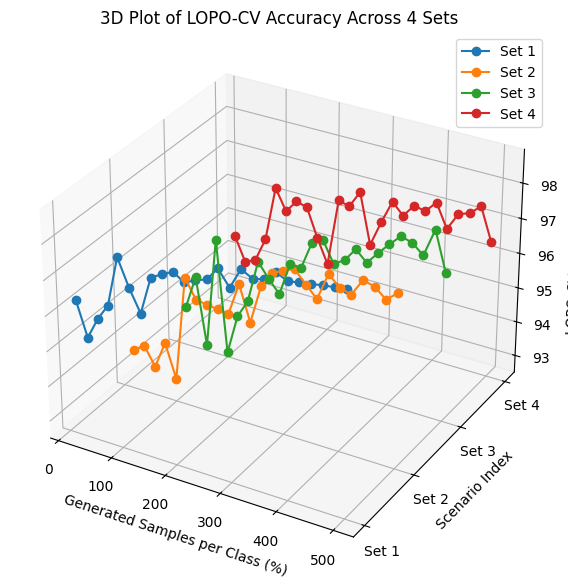

C:\Users\Well\AppData\Local\Temp\ipykernel_25524\808451765.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


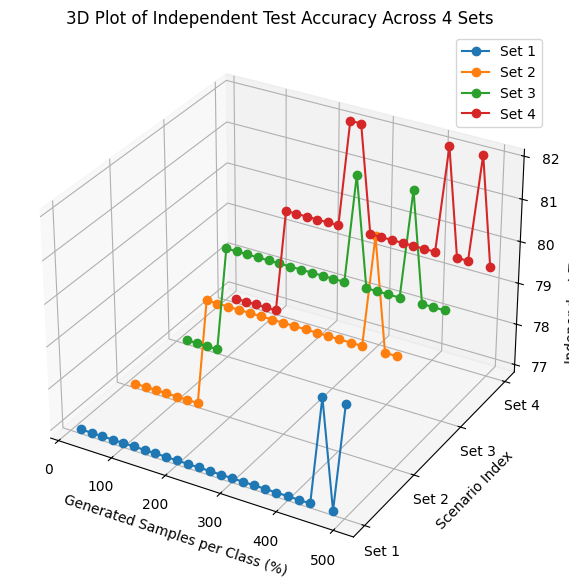

In [ ]:
# --- 1. 載入四組 history ---
paths = [
    '../result_LSVM/BD_MDD/BVAE/ep=0/svm_loocv_test_history.pkl',
    '../result_LSVM/BD_MDD/BVAE/ep=10/svm_loocv_test_history.pkl',
    '../result_LSVM/BD_MDD/BVAE/ep=20/svm_loocv_test_history.pkl',
    '../result_LSVM/BD_MDD/BVAE/ep=30/svm_loocv_test_history.pkl',
]

histories = []
for p in paths:
    with open(p, 'rb') as f:
        histories.append(pickle.load(f))

# --- 2. 提取 gen_counts, LOPO-CV 和獨立測試分數 ---
gen_counts = np.array(histories[0]['gen_counts']) * 2  # 轉換為百分比
loocv_matrix = np.array([h['loocv_scores'] for h in histories]) * 100
test_matrix  = np.array([h['test_scores']  for h in histories]) * 100

# 標籤名稱，可依實際情況調整
labels = [f'Set {i+1}' for i in range(len(histories))]

# --- 3. 繪製 3D 折線圖：LOPO-CV ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for idx, loocv in enumerate(loocv_matrix):
    y = np.full_like(gen_counts, idx)  # 將每組資料 plot 在不同 y 座標
    ax.plot(gen_counts, y, loocv, marker='o', label=labels[idx])

ax.set_xlabel('Generated Samples per Class (%)')
ax.set_ylabel('Scenario Index')
ax.set_zlabel('LOPO-CV Accuracy (%)')
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.view_init(elev=30, azim=-60)
ax.set_title('3D Plot of LOPO-CV Accuracy Across 4 Sets')
ax.legend()
plt.tight_layout()
plt.show()

# --- 4. 繪製 3D 折線圖：獨立測試 ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for idx, test in enumerate(test_matrix):
    y = np.full_like(gen_counts, idx)
    ax.plot(gen_counts, y, test, marker='o', label=labels[idx])

ax.set_xlabel('Generated Samples per Class (%)')
ax.set_ylabel('Scenario Index')
ax.set_zlabel('Independent Test Accuracy (%)')
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.view_init(elev=30, azim=-60)
ax.set_title('3D Plot of Independent Test Accuracy Across 4 Sets')
ax.legend()
plt.tight_layout()
plt.show()

C:\Users\Well\AppData\Local\Temp\ipykernel_25524\1652215792.py:92: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


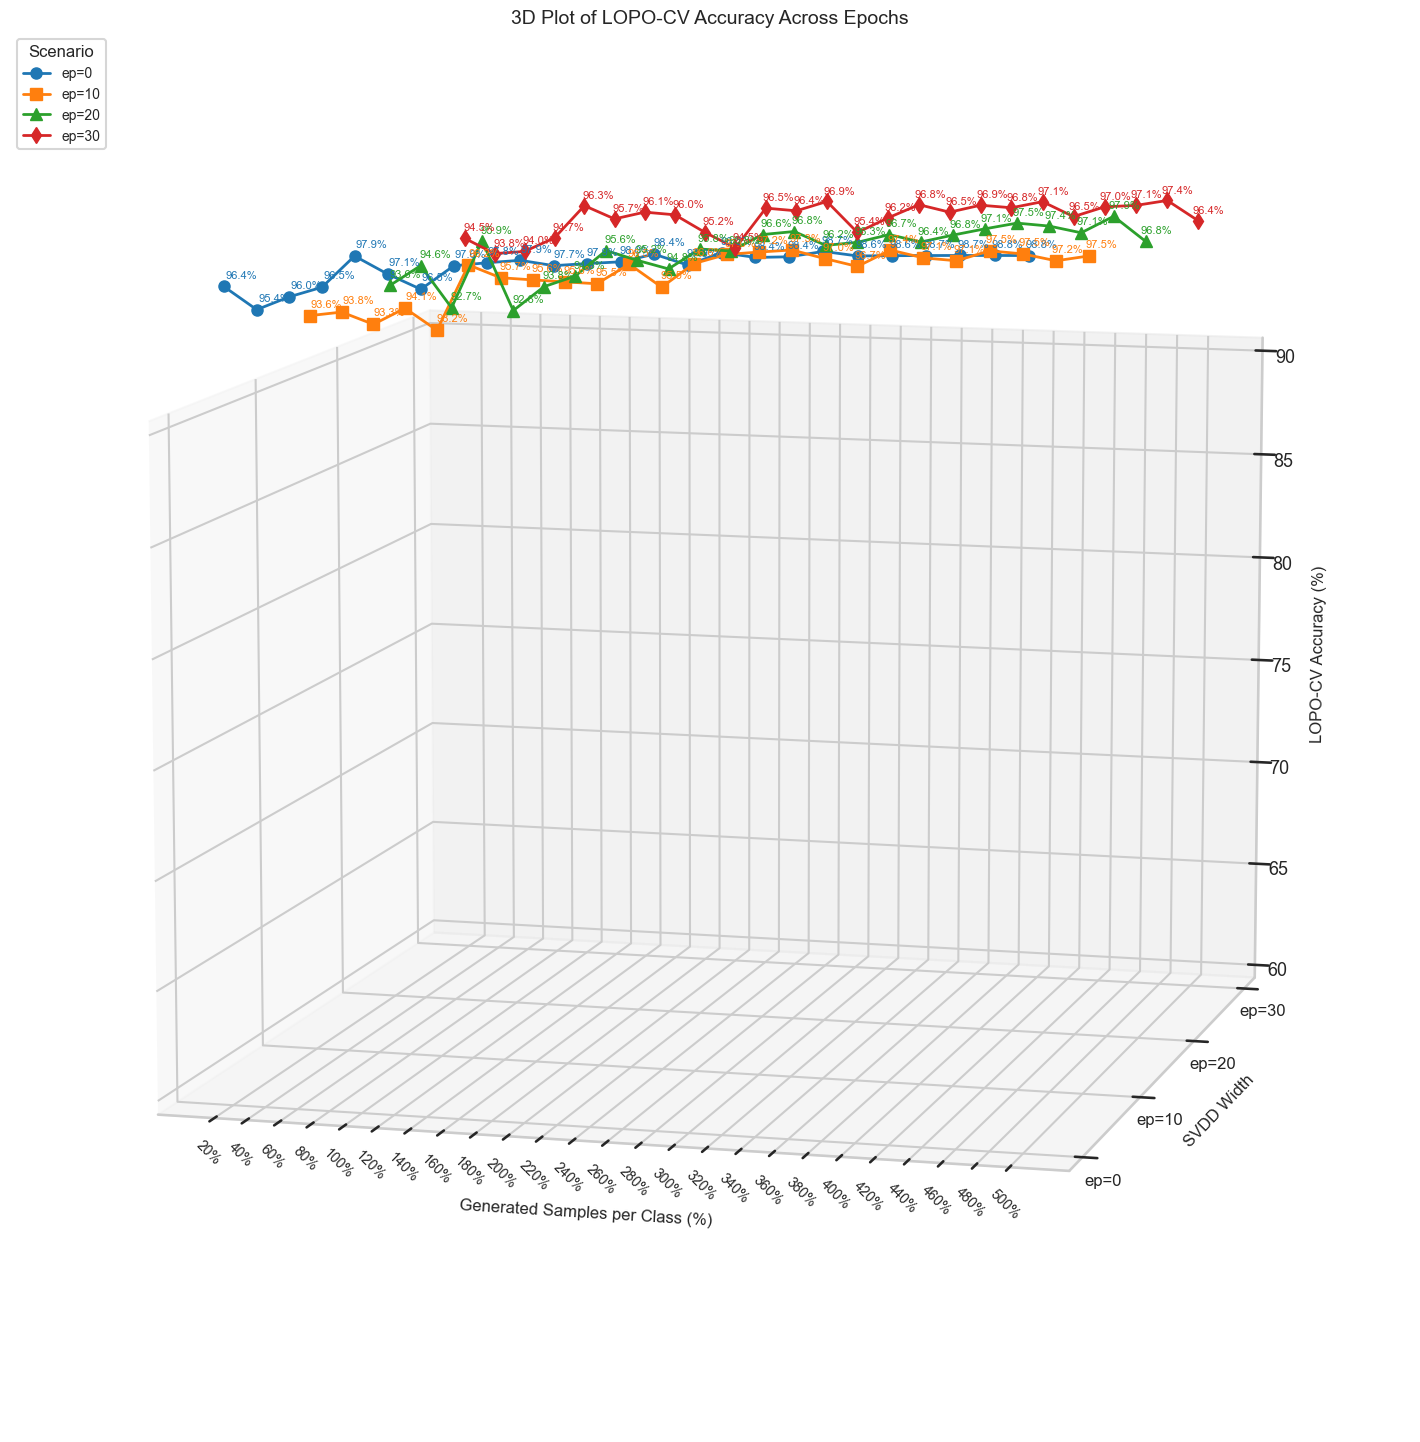

C:\Users\Well\AppData\Local\Temp\ipykernel_25524\1652215792.py:92: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


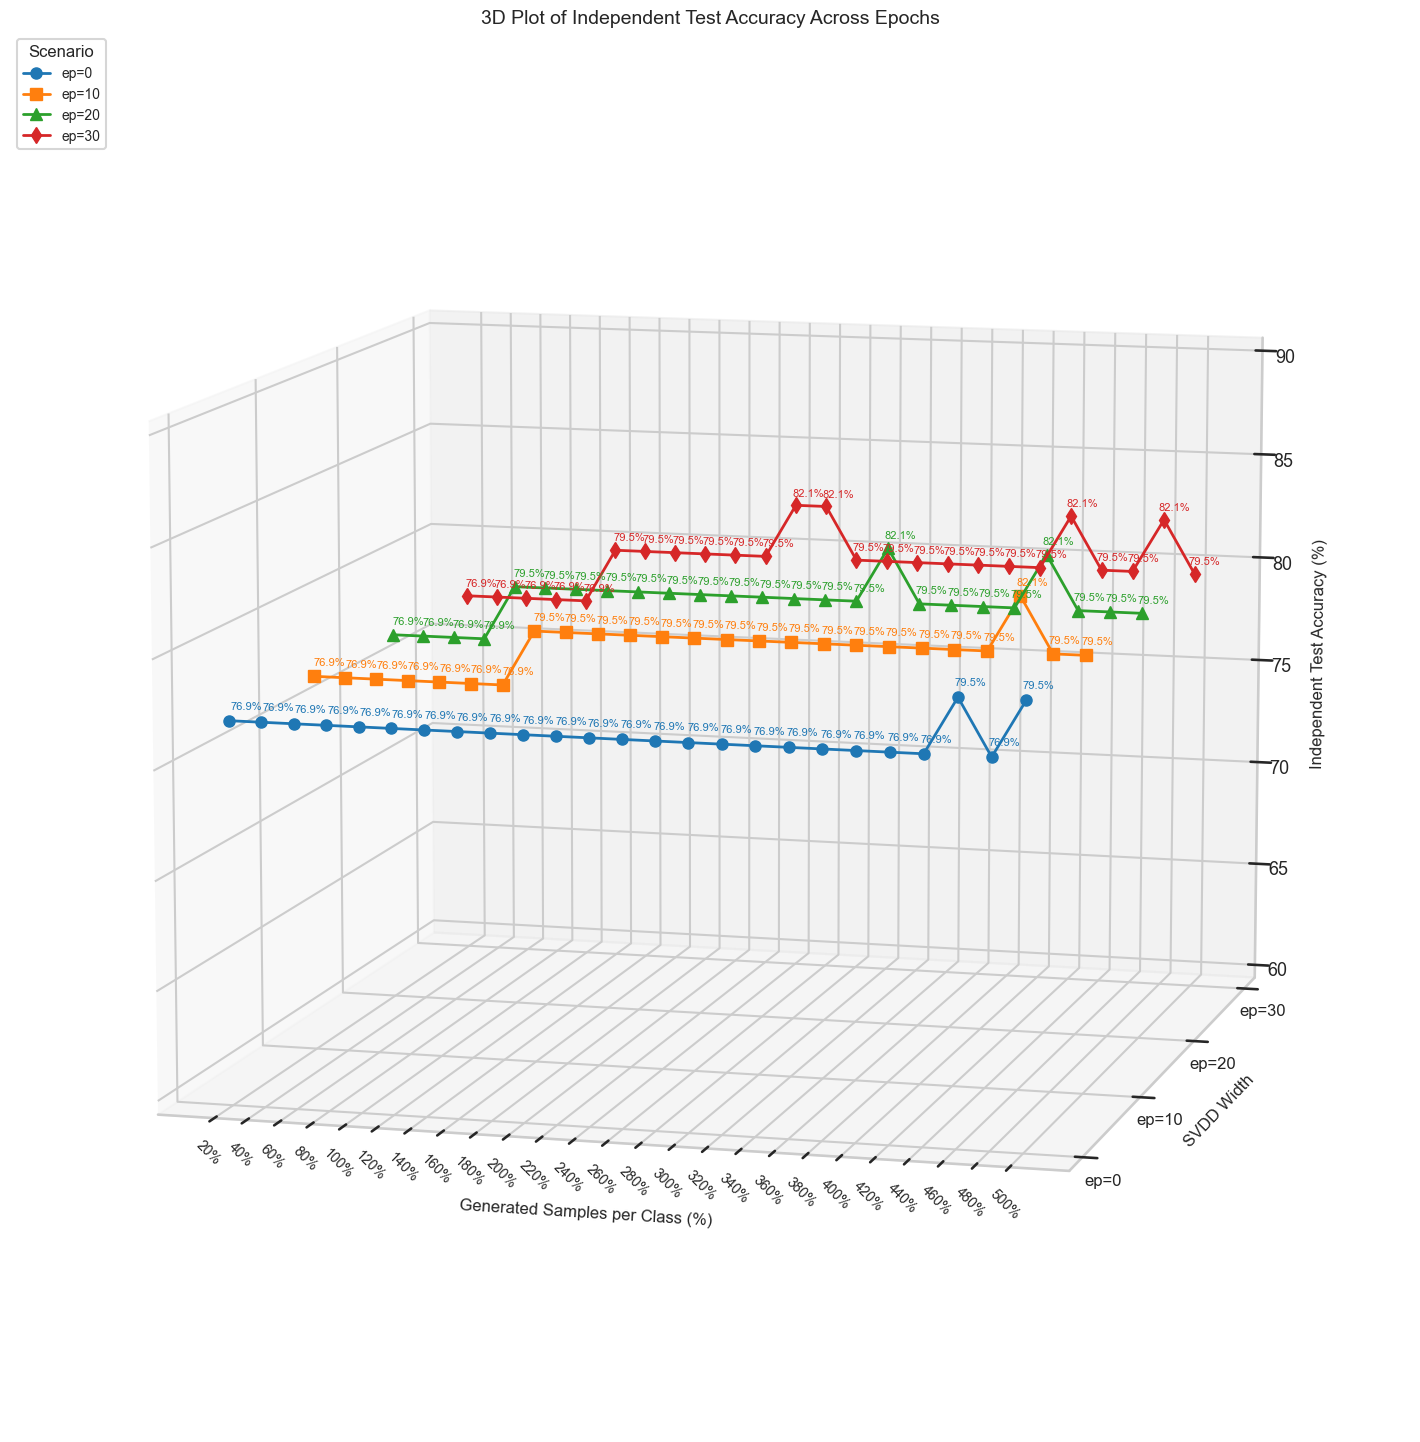

In [47]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def load_histories(paths):
    """
    載入多組 history dict，結構包含 'gen_counts', 'loocv_scores', 'test_scores'。
    找不到檔案時會顯示警告並跳過。
    """
    histories = []
    for p in paths:
        if not os.path.exists(p):
            print(f"Warning: File not found: {p}")
            continue
        with open(p, 'rb') as f:
            hist = pickle.load(f)
            # 驗證必要欄位
            for key in ['gen_counts', 'loocv_scores', 'test_scores']:
                if key not in hist:
                    raise KeyError(f"Missing '{key}' in history loaded from {p}")
            histories.append(hist)
    if not histories:
        raise FileNotFoundError("No valid history files loaded. Please check the paths.")
    return histories

def plot_3d_lines(histories, metric_key, scenario_labels, title, z_label,
                  elev=10, azim=-75, color_map='tab10', marker_map=('o','s','^','d')):
    """
    繪製 3D 折線圖：
      - histories: 載入後的 list of dict
      - metric_key: 'loocv_scores' 或 'test_scores'
      - scenario_labels: y 軸標籤，例如 ['ep=0','ep=10',...]
      - title: 圖片標題
      - z_label: z 軸標籤
    """
    # 提取 gen_counts
    gen_counts = np.array(histories[0]['gen_counts']) * 2  # 轉為百分比
    n_scenarios = len(histories)
    # 將 metric 轉為百分比矩陣
    matrix = np.array([h[metric_key] for h in histories]) * 100

    # 建立圖形
    sns.set_theme(style="whitegrid", context="talk")
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    # 選用色彩與標記
    cmap = plt.get_cmap(color_map)
    colors = [cmap(i) for i in range(n_scenarios)]

    for idx, label in enumerate(scenario_labels):
        y_vals = np.full_like(gen_counts, idx)
        z_vals = matrix[idx]
        ax.plot(
            gen_counts, y_vals, z_vals,
            marker=marker_map[idx % len(marker_map)],
            markersize=8,
            linewidth=2,
            color=colors[idx],
            label=label
        )
        # 在每個點上標註數值
        for x, y, z in zip(gen_counts, y_vals, z_vals):
            ax.text(
                x, y + 0.2, z,
                f"{z:.1f}%",
                fontsize=8,
                ha='center',
                va='bottom',
                color=colors[idx]
            )

    # 軸標籤與刻度
    ax.set_xlabel('Generated Samples per Class (%)', fontsize=12, labelpad=20)
    ax.set_ylabel('SVDD Width', fontsize=12, labelpad=10)
    ax.set_zlabel(z_label, fontsize=12, labelpad=10)

    ax.set_zlim(60, 90)

    ax.tick_params(axis='z', which='major', labelsize=13)
    ax.set_yticks(np.arange(n_scenarios))
    ax.set_yticklabels(scenario_labels, fontsize=12)
    ax.set_xticks(gen_counts)
    ax.set_xticklabels([f"{int(x)}%" for x in gen_counts], fontsize=10, rotation=-45)
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title, fontsize=14)
    ax.legend(title='Scenario', fontsize=10, title_fontsize=12, loc='upper left')
    fig.subplots_adjust(bottom=0.18)
    plt.tight_layout()
    plt.show()

# ======================
# 使用範例
# ======================
if __name__ == '__main__':
    # 1. 指定四個不同訓練回合數對應的路徑
    paths = [
        '../result_LSVM/BD_MDD/BVAE/ep=0/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=10/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=20/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=30/svm_loocv_test_history.pkl',
    ]
    # 2. 載入資料
    histories = load_histories(paths)
    scenario_labels = ['ep=0', 'ep=10', 'ep=20', 'ep=30']

    # 3. 繪製 4 條 LOPO-CV 折線
    plot_3d_lines(
        histories,
        metric_key='loocv_scores',
        scenario_labels=scenario_labels,
        title='3D Plot of LOPO-CV Accuracy Across Epochs',
        z_label='LOPO-CV Accuracy (%)'
    )

    # 4. 繪製 4 條 Independent Test 折線
    plot_3d_lines(
        histories,
        metric_key='test_scores',
        scenario_labels=scenario_labels,
        title='3D Plot of Independent Test Accuracy Across Epochs',
        z_label='Independent Test Accuracy (%)'
    )

C:\Users\Well\AppData\Local\Temp\ipykernel_25524\4041230693.py:111: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


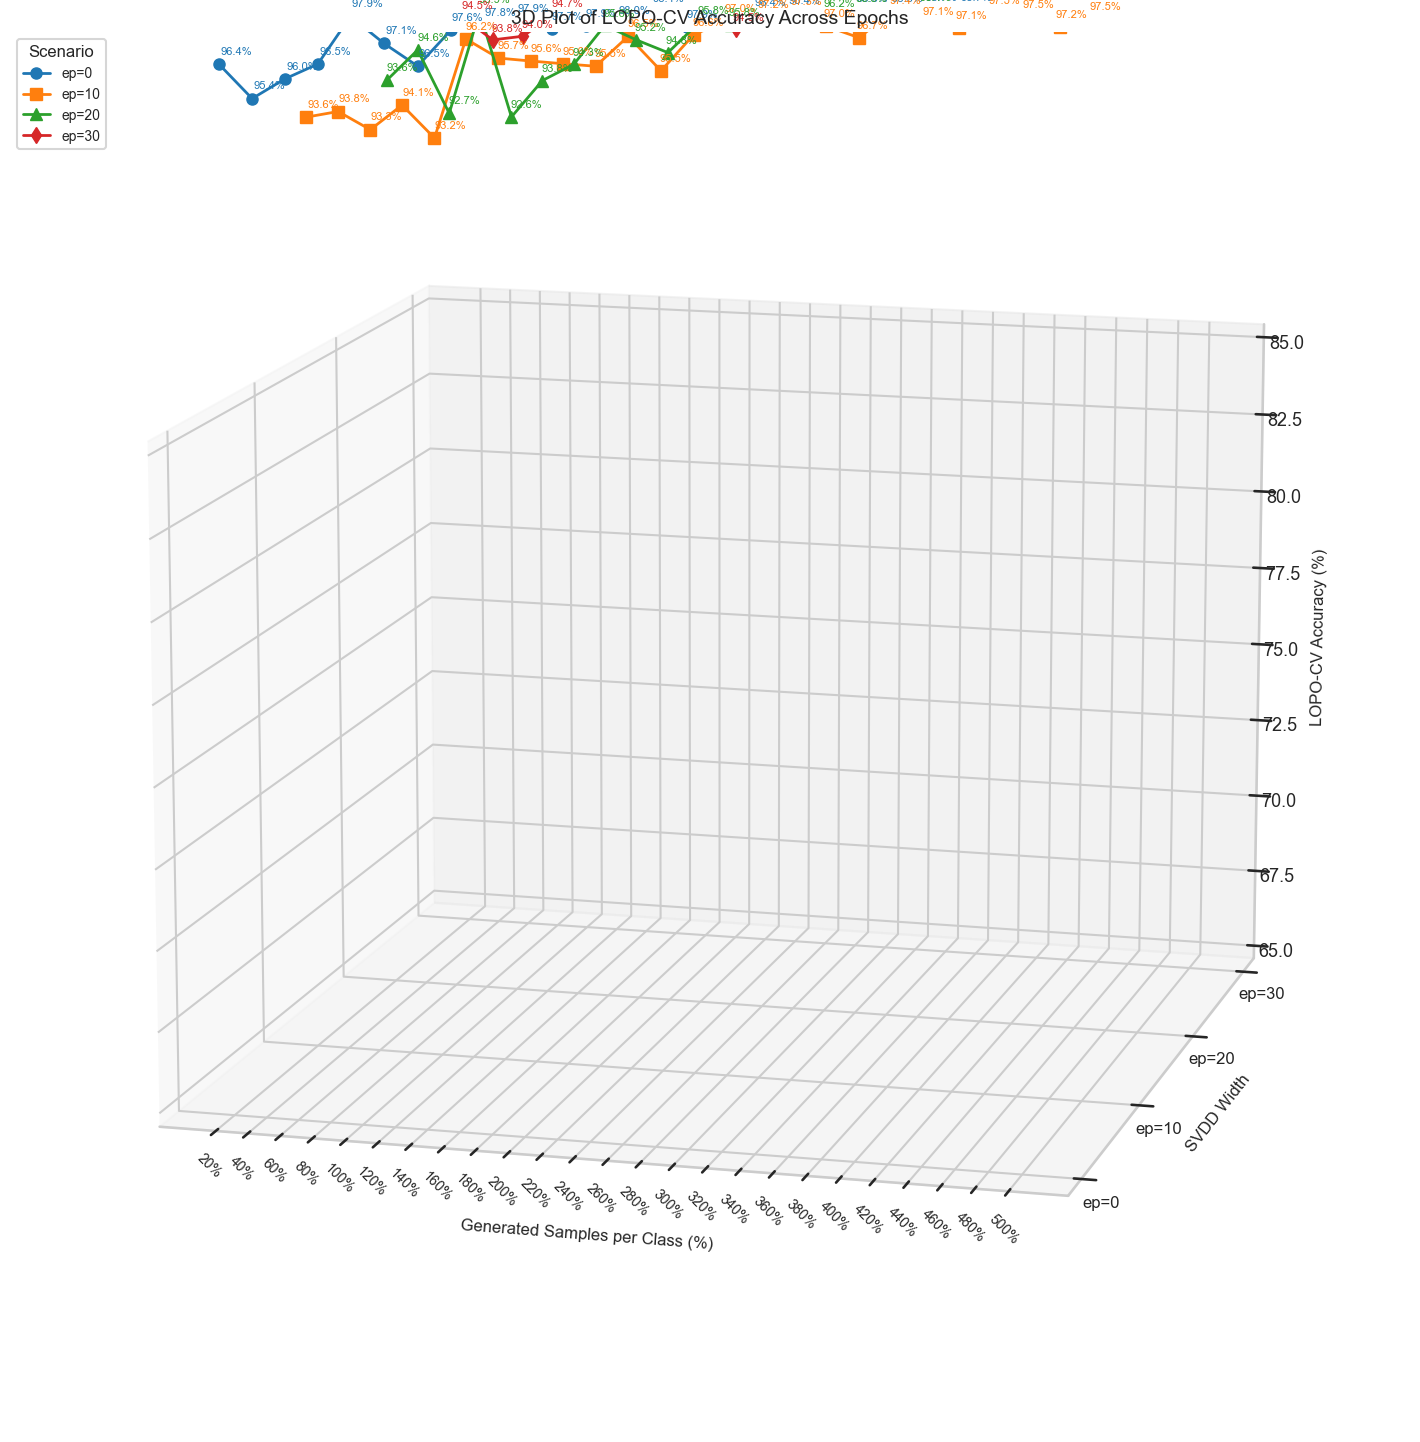

C:\Users\Well\AppData\Local\Temp\ipykernel_25524\4041230693.py:111: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


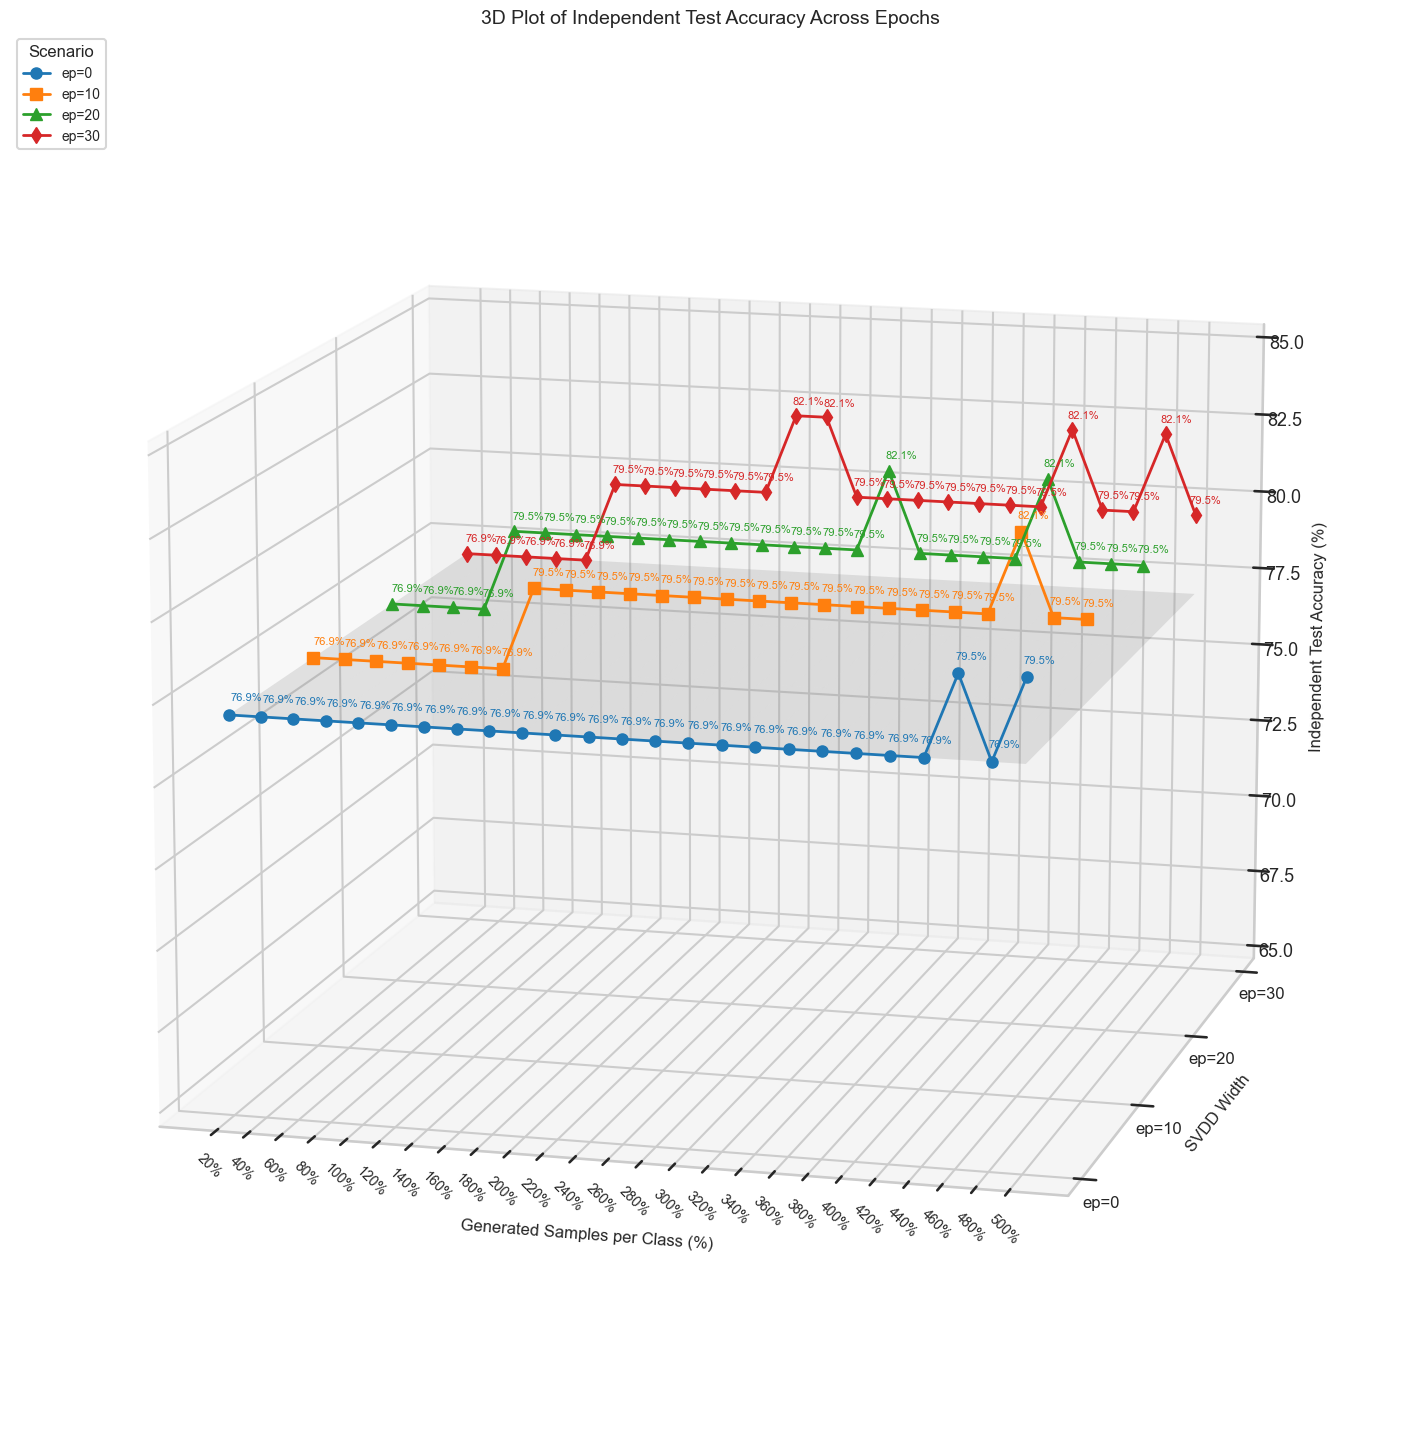

In [53]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def load_histories(paths):
    """
    載入多組 history dict，結構包含 'gen_counts', 'loocv_scores', 'test_scores'。
    找不到檔案時會顯示警告並跳過。
    """
    histories = []
    for p in paths:
        if not os.path.exists(p):
            print(f"Warning: File not found: {p}")
            continue
        with open(p, 'rb') as f:
            hist = pickle.load(f)
            # 驗證必要欄位
            for key in ['gen_counts', 'loocv_scores', 'test_scores']:
                if key not in hist:
                    raise KeyError(f"Missing '{key}' in history loaded from {p}")
            histories.append(hist)
    if not histories:
        raise FileNotFoundError("No valid history files loaded. Please check the paths.")
    return histories

def plot_3d_lines(
    histories,
    metric_key,
    scenario_labels,
    title,
    z_label,
    elev=13,
    azim=-75,
    color_map='tab10',
    marker_map=('o','s','^','d'),
    plane_z=None
):
    """
    繪製 3D 折線圖，並可選擇在指定的 z 值處畫一個水平平面：
      - histories: list of history dicts
      - metric_key: 'loocv_scores' 或 'test_scores'
      - scenario_labels: y 軸標籤
      - title: 圖片標題
      - z_label: z 軸標籤
      - plane_z: 若非 None，則在該 z 值畫平面
    """
    gen_counts = np.array(histories[0]['gen_counts']) * 2  # 百分比
    n_scenarios = len(histories)
    matrix = np.array([h[metric_key] for h in histories]) * 100

    sns.set_theme(style="whitegrid", context="talk")
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    cmap   = plt.get_cmap(color_map)
    colors = [cmap(i) for i in range(n_scenarios)]

    # 繪折線與標註
    for idx, label in enumerate(scenario_labels):
        y_vals = np.full_like(gen_counts, idx)
        z_vals = matrix[idx]
        ax.plot(
            gen_counts, y_vals, z_vals,
            marker=marker_map[idx % len(marker_map)],
            markersize=8,
            linewidth=2,
            color=colors[idx],
            label=label
        )
        for x, y, z in zip(gen_counts, y_vals, z_vals):
            ax.text(
                x, y + 0.2, z,
                f"{z:.1f}%",
                fontsize=8,
                ha='center',
                va='bottom',
                color=colors[idx]
            )

    # 如果指定了 plane_z，就在該 z 值畫一個水平平面
    if plane_z is not None:
        # 建立整個 XY 範圍的格點
        Xp, Yp = np.meshgrid(gen_counts, np.arange(n_scenarios))
        Zp     = np.ones_like(Xp) * plane_z
        ax.plot_surface(
            Xp, Yp, Zp,
            color='gray',
            alpha=0.2,
            linewidth=0,
            shade=False
        )

    # 軸標籤與刻度
    ax.set_xlabel('Generated Samples per Class (%)', fontsize=12, labelpad=20)
    ax.set_ylabel('SVDD Width',             fontsize=12, labelpad=10)
    ax.set_zlabel(z_label,                  fontsize=12, labelpad=10)
    ax.set_zlim(65, 85)
    ax.tick_params(axis='z', which='major', labelsize=13)
    ax.set_yticks(np.arange(n_scenarios))
    ax.set_yticklabels(scenario_labels, fontsize=12)
    ax.set_xticks(gen_counts)
    ax.set_xticklabels([f"{int(x)}%" for x in gen_counts], fontsize=10, rotation=-45)
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title, fontsize=14)
    ax.legend(title='Scenario', fontsize=10, title_fontsize=12, loc='upper left')

    fig.subplots_adjust(bottom=0.18)
    plt.tight_layout()
    plt.show()

# ======================
# 使用範例
# ======================
if __name__ == '__main__':
    paths = [
        '../result_LSVM/BD_MDD/BVAE/ep=0/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=10/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=20/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=30/svm_loocv_test_history.pkl',
    ]
    histories = load_histories(paths)
    scenario_labels = ['ep=0', 'ep=10', 'ep=20', 'ep=30']

    # 3. 繪製 4 條 LOPO-CV 折線（無平面）
    plot_3d_lines(
        histories,
        metric_key='loocv_scores',
        scenario_labels=scenario_labels,
        title='3D Plot of LOPO-CV Accuracy Across Epochs',
        z_label='LOPO-CV Accuracy (%)'
    )

    # 4. 繪製 4 條 Independent Test 折線（加 z=76.92 的水平平面）
    plot_3d_lines(
        histories,
        metric_key='test_scores',
        scenario_labels=scenario_labels,
        title='3D Plot of Independent Test Accuracy Across Epochs',
        z_label='Independent Test Accuracy (%)',
        plane_z=76.92
    )
